# Imports

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mp
from scipy.stats import gaussian_kde

In [ ]:
if 'google.colab' in str(get_ipython()): # running in colab
    !git clone --config lfs.fetchinclude="*"  https://github.com/sinc-lab/revisiting_crossval_RNAfolding.git
    DATA_PATH = './revisiting_crossval_RNAfolding/'
else:
    DATA_PATH = '../'

In [ ]:
DIST_PATH =  DATA_PATH + "data/rnadist_f_all.h5"
d = pd.read_hdf(DIST_PATH)
dist = d / d.max().max()

# utils

In [ ]:
def get_ids(dist, split, fold, partition):
    f = split.query("fold_number == @fold")
    part = f.query("partition == @partition")
    return sorted(set(dist.index) & set(part["id"]))

def get_partition_distances(dist, split, fold, partition1, partition2):
    rows = get_ids(dist, split, fold, partition1)
    cols = get_ids(dist, split, fold, partition2)
    return dist.loc[rows, cols].copy()

def create_dfs(splits, verbose=False):
    splits["partition"] = splits["partition"].apply(
    lambda x: "train" if x in ["train", "valid"] else "test"
    )
    folds = splits.fold_number.unique()
    parts = list(splits.partition.unique())

    dfs = {fold : {s: {p: pd.DataFrame() for p in parts} for s in parts} for fold in folds}
    for fold in folds:
        for p1 in parts:
            for p2 in parts:
                dfs[fold][p1][p2] = get_partition_distances(dist, splits, fold, p1, p2)
                if verbose:
                    print(f"Fold {fold} - {p1} vs {p2}: {dfs[fold][p1][p2].shape}")
    return dfs

def create_stats(dfs, folds):
    stats = {"fold": [], "min": [],"mean": [],"max": [] }
    for fold in folds:
        A = dfs[fold]["train"]["test"].values
        stats["fold"].append(fold)
        stats["min"].append(np.nanmin(A))
        stats["mean"].append(np.nanmean(A))
        stats["max"].append(np.nanmax(A))
    df_stats = pd.DataFrame(stats)
    return df_stats

def create_flat_dfs(dfs, folds):
    dfs_dists = {}
    for fold in folds:
        rows = []
        mat = dfs[fold]['train']['test']
        vals = mat.to_numpy().ravel()
        rows.extend({
            "dist": float(v)
        } for v in vals)

        dfs_dists[fold] = pd.DataFrame(rows)
    return dfs_dists

In [7]:
fig_width1col = 6.75/2
fig_height = 3.0
font_size = 6 # max 7
linew = 0.8

# Random k-fold

In [ ]:
splits = pd.read_csv(DATA_PATH + "data/random_kfolds_split.csv")
folds = splits.fold_number.unique()
folds.sort()
dfs = create_dfs(splits, verbose=False)
dfs_dists = {}
for fold in folds:
    rows = []
    mat = dfs[fold]['train']['test']
    vals = mat.to_numpy().ravel()
    rows.extend({
        "dist": float(v)
    } for v in vals)
    dfs_dists[fold] = pd.DataFrame(rows)

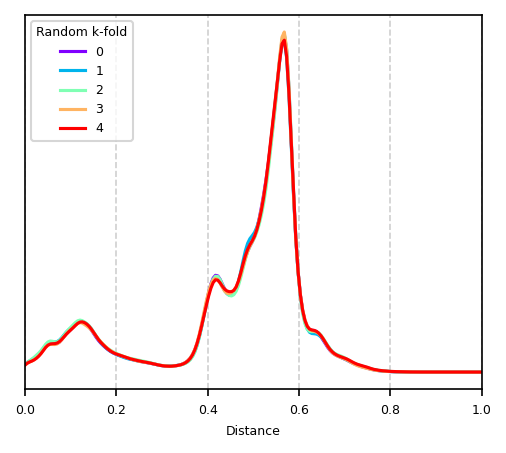

In [12]:
plt.figure(figsize=(fig_width1col, fig_height), dpi=150)
plt.rcParams.update({'font.size': font_size})

cmap = plt.get_cmap('rainbow', lut=len(folds))
colors = [cmap(i) for i in range(len(folds))]
for i, fold in enumerate(folds):
    df = dfs_dists[fold]
    kde = gaussian_kde(df['dist'])
    x_vals = np.linspace(min(df['dist']), max(df['dist']), 200)
    plt.plot(x_vals, kde(x_vals), color=colors[i], label=f"{fold}")
    plt.tight_layout()
plt.xlabel("Distance",fontsize=font_size)
plt.xticks(fontsize=font_size)
plt.tight_layout()
plt.legend(title="Random k-fold", loc="upper left", fontsize=font_size)
plt.gca().axes.get_yaxis().set_visible(False)
plt.xlim(0.0, 1.0)
plt.grid(True, ls="--", alpha=0.6)

plt.savefig(DATA_PATH + "results/figures/Fig1_panelA.pdf", bbox_inches='tight', dpi=300)
plt.show()

# Clustering fold

In [ ]:
splits = pd.read_csv(DATA_PATH +"data/clustering_folds_split.csv")
folds = splits.fold_number.unique()
folds.sort()
dfs = create_dfs(splits, verbose=False)
dfs_dists = {}
for fold in folds:
    rows = []
    for part1, dic in dfs[fold].items():
        for part2, mat in dic.items():
            if part1 != part2:
                vals = mat.to_numpy().ravel()
                rows.extend({
                    "part1": part1,
                    "part2": part2,
                    "dist": float(v)
                } for v in vals)
    dfs_dists[fold] = pd.DataFrame(rows)

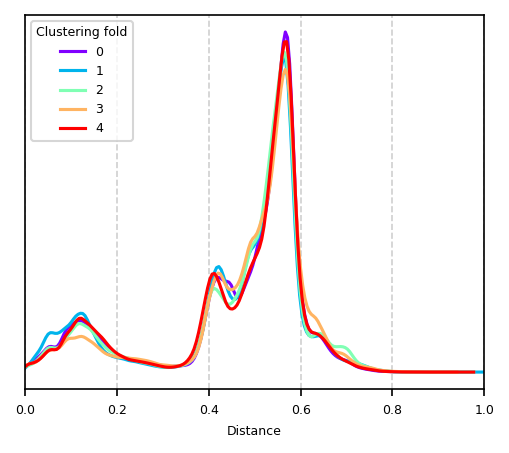

In [14]:
plt.figure(figsize=(fig_width1col, fig_height), dpi=150)
plt.rcParams.update({'font.size': font_size})

cmap = plt.get_cmap('rainbow', lut=len(folds))
colors = [cmap(i) for i in range(len(folds))]
for i, fold in enumerate(folds):
    df = dfs_dists[fold]
    kde = gaussian_kde(df['dist'])
    x_vals = np.linspace(min(df['dist']), max(df['dist']), 200)
    plt.plot(x_vals, kde(x_vals), color=colors[i], label=f"{fold}")
    plt.tight_layout()
plt.xlabel("Distance",fontsize=font_size)
plt.xticks(fontsize=font_size)
plt.tight_layout()
plt.legend(title="Clustering fold", loc="upper left", fontsize=font_size)
plt.grid(True, ls="--", alpha=0.6)
plt.xlim(0.0, 1.0)
plt.gca().axes.get_yaxis().set_visible(False)

plt.savefig(DATA_PATH + "results/figures/Fig1_panelB.pdf", bbox_inches='tight', dpi=300)
plt.tight_layout()
plt.show()

# Family fold

In [ ]:
splits = pd.read_csv(DATA_PATH +"data/fam_folds_split.csv")
folds = splits.fold_number.unique()
folds.sort()
dfs = create_dfs(splits, verbose=False)
dfs_dists = {}
for fold in folds:
    rows = []
    for part1, dic in dfs[fold].items():
        for part2, mat in dic.items():
            # train/test (part1 != part2)
            if part1 != part2:
                vals = mat.to_numpy().ravel()
                rows.extend({
                    "part1": part1,
                    "part2": part2,
                    "dist": float(v)
                } for v in vals)

    dfs_dists[fold] = pd.DataFrame(rows)

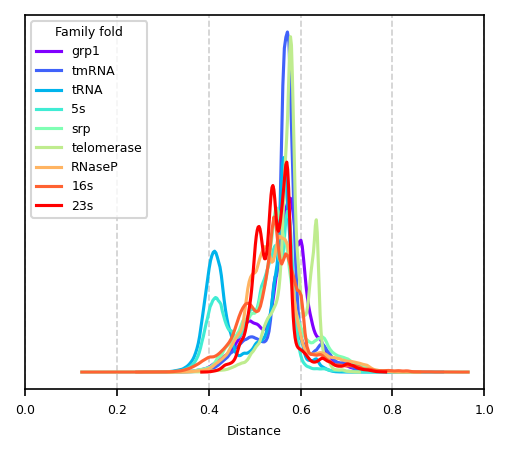

In [18]:
plt.figure(figsize=(fig_width1col, fig_height), dpi=150)
plt.rcParams.update({'font.size': font_size})

cmap = plt.get_cmap('rainbow', lut=len(folds))
colors = [cmap(i) for i in range(len(folds))]
folds_name = list(splits['fold_name'].unique())
for i, fold in enumerate(folds):
    df = dfs_dists[fold]
    kde = gaussian_kde(df['dist'])
    x_vals = np.linspace(min(df['dist']), max(df['dist']), 200)
    plt.plot(x_vals, kde(x_vals), color=colors[i], label=f"{folds_name[fold]}")
    plt.tight_layout()
plt.xlabel("Distance",fontsize=font_size)
plt.xticks(fontsize=font_size)
plt.tight_layout()
plt.legend(title="Family fold", loc="upper left", fontsize=font_size)
plt.grid(True, ls="--", alpha=0.6)
plt.xlim(0.0, 1.0)
plt.gca().axes.get_yaxis().set_visible(False)

plt.savefig(DATA_PATH + "results/figures/Fig1_panelC.pdf", bbox_inches='tight', dpi=300)
plt.tight_layout()
plt.show()

# Human learned fold

In [ ]:
splits = pd.read_csv(DATA_PATH +"data/hl_folds_split.csv")
folds = splits.fold_number.unique()
folds.sort()
dfs = create_dfs(splits, verbose=False)
dfs_dists = {}
for fold in folds:
    rows = []
    for part1, dic in dfs[fold].items():
        for part2, mat in dic.items():
            if part1 != part2:
                vals = mat.to_numpy().ravel()
                rows.extend({
                    "part1": part1,
                    "part2": part2,
                    "dist": float(v)
                } for v in vals)

    dfs_dists[fold] = pd.DataFrame(rows)

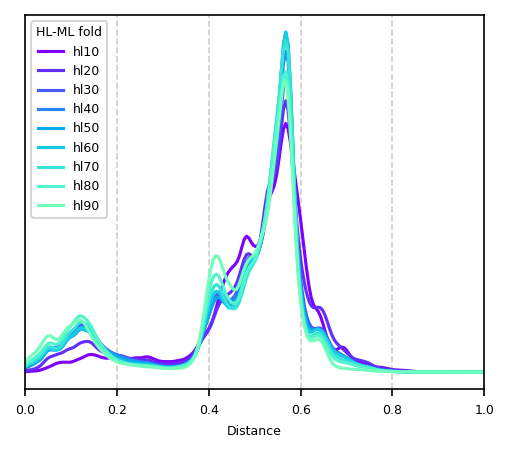

In [23]:
plt.figure(figsize=(fig_width1col, fig_height), dpi=150)
plt.rcParams.update({'font.size': font_size})

cmap = plt.get_cmap('rainbow', lut=len(folds))
colors = [cmap(i) for i in range(len(folds))]
folds_name = list(splits['fold_name'].unique())
folds = [0,2,4,6,8,10,12,14,16] # use tens folds
for i, fold in enumerate(folds):
    df = dfs_dists[fold]
    kde = gaussian_kde(df['dist'])
    x_vals = np.linspace(min(df['dist']), max(df['dist']), 200)
    plt.plot(x_vals, kde(x_vals), color=colors[i], label=f"{folds_name[fold]}")
    plt.tight_layout()
plt.xlabel("Distance",fontsize=font_size)
plt.xticks(fontsize=font_size)
plt.tight_layout()
plt.legend(title="HL-ML fold", loc="upper left", fontsize=font_size)
plt.grid(True, ls="--", alpha=0.6)
plt.gca().axes.get_yaxis().set_visible(False)
plt.xlim(0.0, 1.0)

plt.savefig(DATA_PATH + "results/figures/Fig1_panelD.pdf", bbox_inches='tight', dpi=300)
plt.tight_layout()
plt.show()

# Similarity fold

In [24]:
splits_path = DATA_PATH +"data/sim_folds_split/"
splits_list = os.listdir(splits_path)
splits_list.sort()
splits = {}
for split in splits_list:
    splits[split] = pd.read_csv(splits_path+split)
folds = splits[splits_list[1]].fold_number.unique()
folds.sort()
for split in splits_list:
    splits[split]["partition"] = splits[split]["partition"].apply(
        lambda x: "train" if x in ["train", "valid"] else "test"
    )
parts = list(splits[split].partition.unique())
splits[splits_list[0]].partition.unique()
dfs = {split : {s: {p: pd.DataFrame() for p in parts} for s in parts} for split in splits_list}
for split in splits_list:
    for p1 in parts:
        for p2 in parts:
            dfs[split][p1][p2] = get_partition_distances(dist, splits[split], 0, p1, p2)
dfs_dists = {}
for split in splits_list:
    rows = []
    for part1, dic in dfs[split].items():
        for part2, mat in dic.items():
            if part1 != part2:
                vals = mat.to_numpy().ravel()
                rows.extend({
                    "part1": part1,
                    "part2": part2,
                    "dist": float(v)
                } for v in vals)

    dfs_dists[split] = pd.DataFrame(rows)

/tmp/ipykernel_63329/1772550097.py:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Similarity fold", loc="upper left", fontsize=font_size)


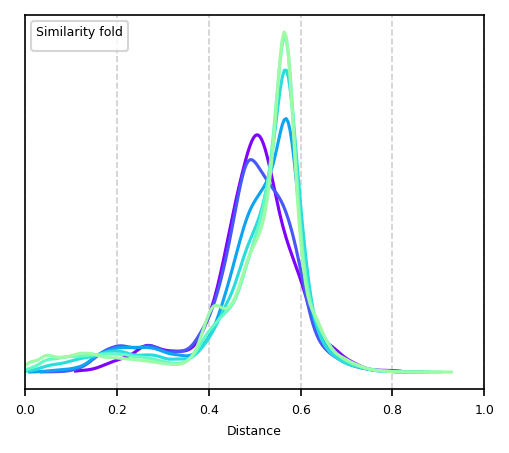

In [25]:
splits_list=splits_list[1:]
plt.figure(figsize=(fig_width1col, fig_height), dpi=150)
plt.rcParams.update({'font.size': font_size})

cmap = plt.get_cmap('rainbow', lut=len(folds))
colors = [cmap(i) for i in range(len(folds))]
for i, split in enumerate(splits_list):
    df = dfs_dists[split]
    kde = gaussian_kde(df['dist'])
    x_vals = np.linspace(min(df['dist']), max(df['dist']), 200)
    plt.plot(x_vals, kde(x_vals), color=colors[i], label=f"{split[53:-9]}")
    plt.tight_layout()
plt.xlim(0.0, 1.0)
plt.xlabel("Distance",fontsize=font_size)
plt.xticks(fontsize=font_size)
plt.tight_layout()
plt.legend(title="Similarity fold", loc="upper left", fontsize=font_size)
plt.grid(True, ls="--", alpha=0.6)
plt.gca().axes.get_yaxis().set_visible(False)

plt.savefig(DATA_PATH + "results/figures/Fig1_panelE.pdf", bbox_inches='tight', dpi=300)
plt.tight_layout()
plt.show()